In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sbsde.distribution import MixMultiVariateNormal, PriorNormal
from sbsde.loss import compute_loss
from sbsde.model import ToyModel
from sbsde.sde import VESDE, Direction
from sbsde.utils import flatten_dim01
from tqdm.auto import trange

/home/pc3090/research/sbsde/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 1000
sigma_min = 1e-2
sigma_max = 5
num_iter = 2000
retrain = True

In [3]:
out_dir = Path("out")
out_dir.mkdir(parents=True, exist_ok=True)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
p_data = MixMultiVariateNormal(batch_size)
p_prior = PriorNormal(sigma_max, device)
sde = VESDE(p_data, p_prior, device, sigma_min, sigma_max)
net_f = ToyModel().to(device)
net_b = ToyModel().to(device)

optimizer_f = optim.AdamW(net_f.parameters(), lr=1e-4)
optimizer_b = optim.AdamW(net_b.parameters(), lr=1e-4)

In [6]:
if (out_dir / "ckpt.pth").exists() and not retrain:
    print("Load pretrained checkpoint")
    net_f.load_state_dict(torch.load(out_dir / "ckpt.pth")["net_f"])
    net_b.load_state_dict(torch.load(out_dir / "ckpt.pth")["net_b"])

In [7]:
net_f.train()
net_b.train()
losses = []
bar = trange(num_iter)
for it in bar:
    optimizer_f.zero_grad()
    optimizer_b.zero_grad()
    xs_f, zs_f, x_term_f = sde.sample_traj(net_f)
    _ts = sde.ts.repeat(batch_size)
    xs_f = flatten_dim01(xs_f)
    zs_f = flatten_dim01(zs_f)
    loss = compute_loss(sde, net_b, _ts, xs_f, x_term_f, zs_f)
    loss.backward()
    optimizer_f.step()
    optimizer_b.step()
    bar.set_postfix(loss=loss.item())
    losses.append(loss.item())

 34%|███▍      | 679/2000 [03:45<07:17,  3.02it/s, loss=6.03]

In [ ]:
plt.plot(range(1, num_iter), losses)

In [ ]:
torch.save(
    {
        "net_f": net_f.state_dict(),
        "net_b": net_b.state_dict(),
        "optimizer_f": optimizer_f.state_dict(),
        "optimizer_b": optimizer_b.state_dict(),
    },
    out_dir / "ckpt.pth",
)

/home/pc3090/research/sbsde/.venv/lib/python3.10/site-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


Text(0.5, 1.0, 'p_prior')

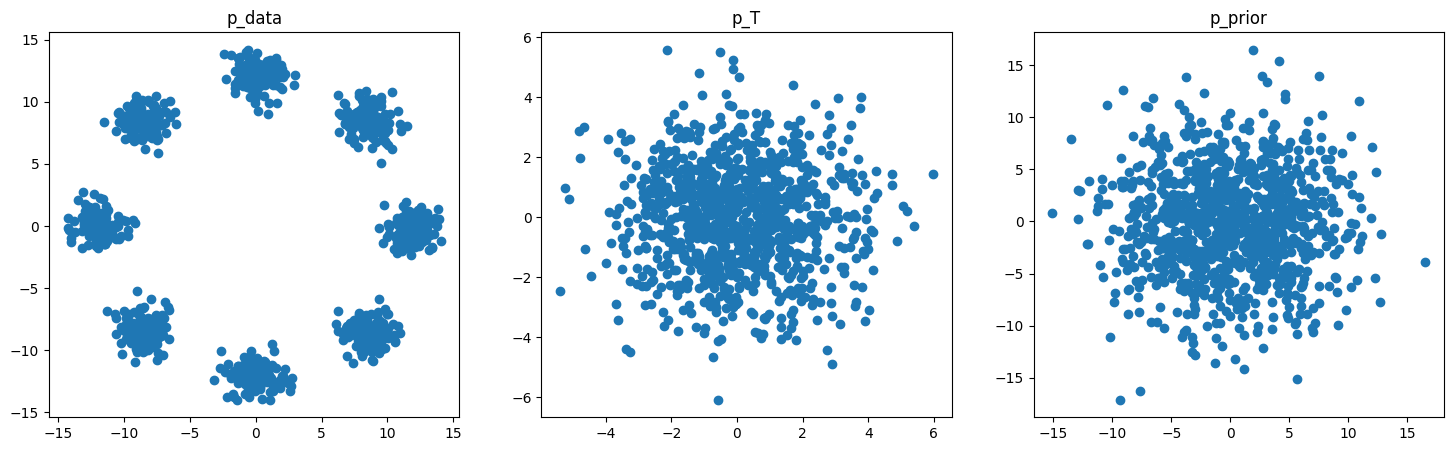

In [ ]:
net_f.eval()
x = sde.p_data.sample_n(1024)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].plot(x[:, 0], x[:, 1], "o")
axes[0].set_title("p_data")
x = x.to(device)
for t in sde.ts:
    with torch.no_grad():
        z = net_f(t, x)
        x = sde.propagate(t, x, z, Direction.FORWARD)
x = x.detach().cpu().numpy()
axes[1].plot(x[:, 0], x[:, 1], "o")
axes[1].set_title("p_T")
x = sde.p_prior.sample_n(1024).cpu().numpy()
axes[2].plot(x[:, 0], x[:, 1], "o")
axes[2].set_title("p_prior")

Text(0.5, 1.0, 'p_data')

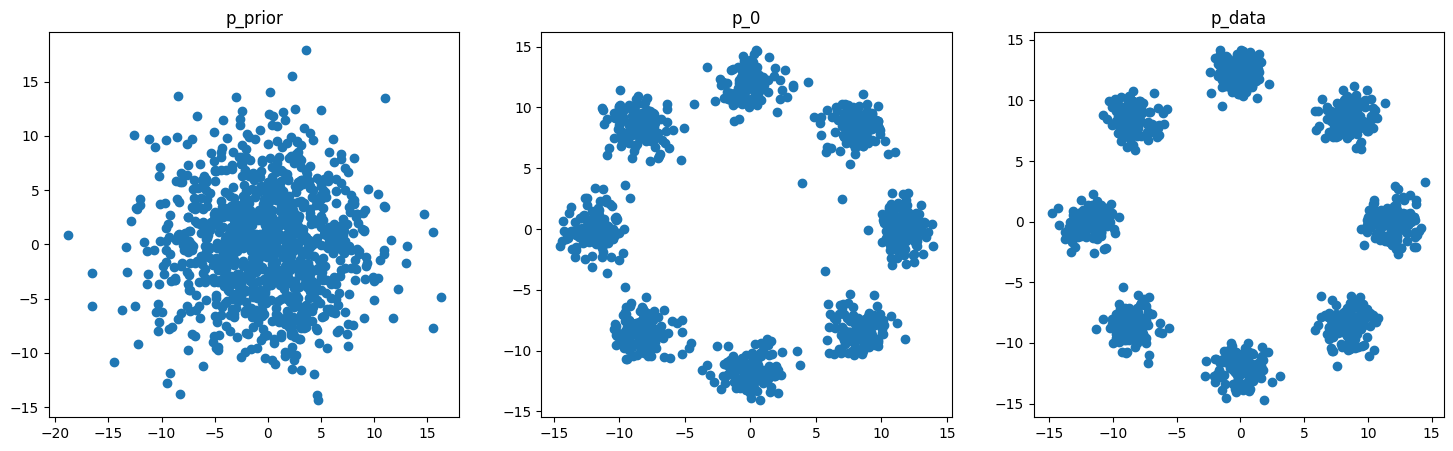

In [ ]:
net_b.eval()
x = sde.p_prior.sample_n(1024).cpu()
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].plot(x[:, 0], x[:, 1], "o")
axes[0].set_title("p_prior")
x = x.to(device)
for t in reversed(sde.ts):
    with torch.no_grad():
        z = net_b(t, x)
        x = sde.propagate(t, x, z, Direction.BACKWARD)
x = x.detach().cpu().numpy()
axes[1].plot(x[:, 0], x[:, 1], "o")
axes[1].set_title("p_0")
x = sde.p_data.sample_n(1024)
axes[2].plot(x[:, 0], x[:, 1], "o")
axes[2].set_title("p_data")